# Imports and data

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import seaborn as sns
import utils.base_utils as bu
import utils.window_utils as wu
import numpy as np
from utils.macro_grouping import add_group_level, build_full_group_mapping, groups_as_array

# Bianchi period:
start_date = '1971-08-31'
end_date = '2018-12-31'


# end_date = '2025-06-30' # kr and gsw end date
maturities = [str(i) for i in range(12, 121) if i % 12 == 0] # select only yearly maturities

yields = bu.get_yields(type='kr', start=start_date, end=end_date, maturities=maturities) # type can be kr, lw, gsw
forward = bu.get_forward_rates(yields)
xr = bu.get_excess_returns(yields, horizon=12).dropna() # horizon=12 means holding for 12 months
fred_md_raw = bu.get_fred_data('data/2026-01-MD.csv', start=start_date, end=end_date) # this is aligned to the last day of the previous month, so we get the same number of observations as the yields data

monthly_yields = bu.get_yields(type='kr', start=start_date, end=end_date, maturities=[str(i) for i in range(1, 121)]) # needed for monthly holding period excess returns. Not available for gsw
monthly_xr = bu.get_excess_returns(monthly_yields, horizon=1).dropna() # calculate monthly excess returns for robustness

# At time t (end of month), we only know data for month t-1
fred_md = fred_md_raw.shift(1)  

# Drop dates outside the xr range
yields = yields.loc[yields.index <= xr.index[-1]]
forward = forward.loc[forward.index <= xr.index[-1]]
xr = xr.loc[xr.index <= xr.index[-1]]
fred_md = fred_md.loc[fred_md.index <= xr.index[-1]]
monthly_xr = monthly_xr.loc[monthly_xr.index <= xr.index[-1]]

# Backfill fred_md to avoid nans
fred_md = fred_md.bfill()

# Construct X with 3-level MultiIndex: (source, group, series)
s2g = build_full_group_mapping(fred_md, forward, yields)

X = pd.concat([fred_md, forward, yields],
               axis=1,
               keys=['fred', 'forward', 'yields'])

X = add_group_level(X, s2g, level_name='group')
X = X.sort_index(axis=1, level='group')
groups = groups_as_array(X, level='group')

y_all = xr[['24','36','48','60','72','84','96','108','120']].values
dates = xr.index

# Expanding window estimation

In [8]:
from models.base import *
from models.classical import *
from models.other import *
from models.ann import *
from models.gbt import *
from models.linear import *
from models.tree import *

# y = monthly_xr['120'].values # 1-month excess returns
y = xr['120'].values # 10-year overlapping excess returns
OOS_start = pd.Timestamp('1990-01-31')
# OOS_start = pd.Timestamp('1972-01-31')

seeds = [1]
coefs = []

def record_coef(coef):
    coefs.append(np.abs(coef).copy())  # store absolute value

for seed in seeds:
    print(f"Running seed {seed}...")
    # Models to test
    models = {
        # 'Lasso': LassoModel(series='forward'),
        # 'Ridge': RidgeModel(series='forward'),
        # 'ExtraTrees': ExtraTreesModel(features={
        #     'forward': {'method': 'raw'},
        # }),
        # 'Linear': LinearModel(),
        # 'PCA': PCABaselineModel(components=3, series='forward'),
        # 'PCAPlusN': PCABaselineModelPlusN(components=3, series='forward', n_extra=3),
        # 'PCAMacroGroups': PCABaselineModelMacroGroups(components=3, series='forward', lasso=True, alpha=0.01),
        # 'PCAMacroGroups': PCABaselineModelMacroGroups(components=3, series='forward', lasso=False, alpha=0.01),
        'GroupPCARF': GroupPCARandomForest(components=3, series='forward', macro_pcs=1),
        # 'GroupLasso': GroupLassoModel(alpha=0.01, groups=groups),
        # 'RW': RandomWalkModel(),
        # 'Mean': HistoricalMeanModel(),
        # 'CP': CochranePiazzesiModel(),
        # 'LN': LudvigsonNgModel(),
        # 'LN_BH': LudvigsonNgBauerHamiltonSpec(),
        # 'BianchiENet': BianchiElasticNet()
    }

    results = {}

    for name, model in models.items():
        print(f"Running {name}...")
        y_forecast_bianchi = wu.expanding_window(
            model, X, y, dates, OOS_start, 
            gap=11, 
            val_len=None,    # Trigger Bianchi internal split
            refit_freq=1,     # Refit every month
            # coef_callback=record_coef # Only implemented for linear models (ols, lasso, ridge, elasticnet). Comment out if not applicable.
        )

        # y_forecast_gkx = wu.expanding_window( # GKX is included as a robustness check, but not the main focus of the paper, so we use the same refit_freq and val_len as Bianchi for simplicity. Currently only implemented for Lasso
        #     model, X, y, dates, OOS_start, 
        #     gap=0,         # Safety for annual returns
        #     val_len=144,     # 12 years of validation
        #     refit_freq=12    # Annual refit
        #     coef_callback=None
        # )

        # Report both in your results table
        for bench_name, bench in [('zero (EH)', 'zero'), ('hist_mean (C-T)', 'hist_mean')]:
            r2 = wu.oos_r2(y, y_forecast_bianchi, benchmark=bench)
            print(f"  B: R2_OOS [{bench_name}] = {r2:.4f}")        

        # for bench_name, bench in [('zero (EH)', 'zero'), ('hist_mean (C-T)', 'hist_mean')]:
        #     r2 = wu.oos_r2(y, y_forecast_gkx, benchmark=bench)
        #     print(f"  GKX: R2_OOS [{bench_name}] = {r2:.4f}")

Running seed 1...
Running GroupPCARF...


100%|██████████| 336/336 [03:15<00:00,  1.72it/s]

  B: R2_OOS [zero (EH)] = -0.1181
  B: R2_OOS [hist_mean (C-T)] = -0.2677


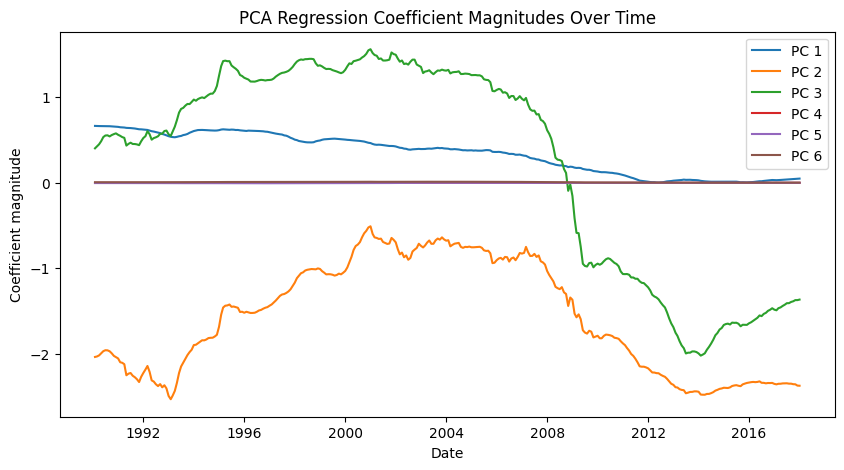

In [6]:
import matplotlib.pyplot as plt
import numpy as np

coefs_arr = np.stack(coefs)  # shape: (n_steps, n_features)
oos_dates = dates[dates >= OOS_start]  # or whatever your OOS date logic is

plt.figure(figsize=(10, 5))
for i in range(coefs_arr.shape[-1]):
    plt.plot(oos_dates, coefs_arr[:, i], label=f'PC {i+1}')
plt.xlabel('Date')
plt.ylabel('Coefficient magnitude')
plt.title('PCA Regression Coefficient Magnitudes Over Time')
plt.legend()
plt.show()

In [6]:
dynamic_r2 = []
oos_indices = np.where(dates >= OOS_start)[0]
for t in range(1, len(oos_dates)+1):
    # y_true and y_pred up to current OOS step
    y_true_cum = y[oos_indices[:t]]
    y_pred_cum = y_forecast_bianchi[oos_indices[:t]]
    r2_cum = wu.oos_r2(y_true_cum, y_pred_cum, benchmark='hist_mean')
    dynamic_r2.append(r2_cum)

plt.plot(oos_dates[100:], dynamic_r2[100:])
plt.xlabel('Date')
plt.ylabel('Cumulative OOS R²')
plt.title('Cumulative OOS R² Over Time')
plt.show()

NameError: name 'oos_dates' is not defined

<Axes: xlabel='date'>

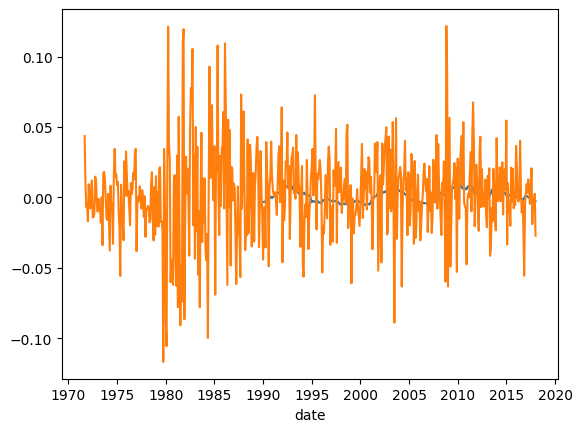

In [10]:
sns.lineplot(y=y_forecast_bianchi, x=yields.index)
sns.lineplot(y=y, x=yields.index)

# Neural networks with multiple outputs:

In [4]:
from models.ann import ForwardRateANN, NN3LayerExog, NN1LayerEnsemExog

# OOS_start = pd.Timestamp('1990-01-31')
OOS_start = pd.Timestamp('2015-01-31')

# y = xr['120'].values # 10-year excess returns
# y = monthly_xr['120'].values # 1-month excess returns for robustness
y_all = xr[['24','36','48','60','72','84','96','108','120']].values

dates = xr.index

models = {
    # Forward rates only (simple)
    # 'FwdANN': ForwardRateANN(hidden_size=3, series='forward', 
    #                           do_grid_search=True, tune_every=48),
    
    # Deep macro (32→16→8) + yields merge
    # 'NN3Layer': NN3LayerExog(macro_series='fred', yield_series='yields',
    #                           do_grid_search=True, tune_every=48),
    
    # Per-group ensemble (→1 each) + yields merge
    'Ensemble': NN1LayerEnsemExog(macro_series='fred', yield_series='yields',
                                   groups=groups,
                                   do_grid_search=True, tune_every=48),
}

# All use the same API:
for name, model in models.items():
    y_forecast = wu.expanding_window(model, X, y_all, dates, OOS_start, gap=0)
    r2s = wu.oos_r2(y_all, y_forecast, benchmark='zero')
    print("\n--- OOS R² Summary ---")
    for mat, r2 in zip(['24','36','48','60','72','84','96','108','120'], r2s):
        print(f"  {mat}m: {r2:.4f}")

  3%|▎         | 1/36 [00:58<33:53, 58.10s/it]


KeyboardInterrupt: 

  24m: -16.6538
  36m: -5.0938
  48m: -3.6507
  60m: -0.2316
  72m: -0.8471
  84m: -0.4044
  96m: -0.4084
  108m: 0.0088
  120m: -0.1207


In [ ]:
y_forecast

array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       ...,
       [-2.47977511e-03,  6.07415661e-03,  1.37296021e-02, ...,
         1.35486592e-02,  2.19769292e-02,  1.14702266e-02],
       [ 6.69859489e-03,  8.01254716e-03,  1.19314659e-02, ...,
         9.72973928e-03,  1.43394321e-02,  1.68175902e-02],
       [-3.11060809e-04, -9.07673384e-05,  4.64147702e-03, ...,
         1.86797231e-02,  1.48781389e-02,  2.17592828e-02]])

<Axes: xlabel='date'>

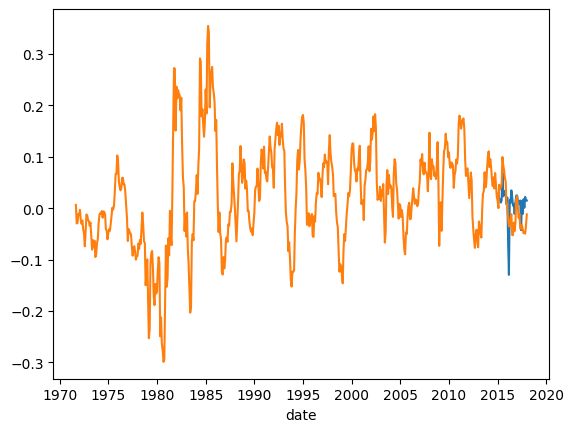

In [ ]:
sns.lineplot(y=y_forecast[:, 7], x=yields.index)
sns.lineplot(y=y_all[:, 7], x=yields.index)

# Test in-sample fit

In [ ]:
# full-sample R2 for comparison
y = xr['36'].values
model = HistoricalMeanModel()
model.fit(X, y)
r2_full = sklearn.metrics.r2_score(y, model.predict(X))
r2_full

TypeError: Input should have at least 1 dimension i.e. satisfy `len(x.shape) > 0`, got scalar `array(0.00979472)` instead.

<Axes: xlabel='date'>

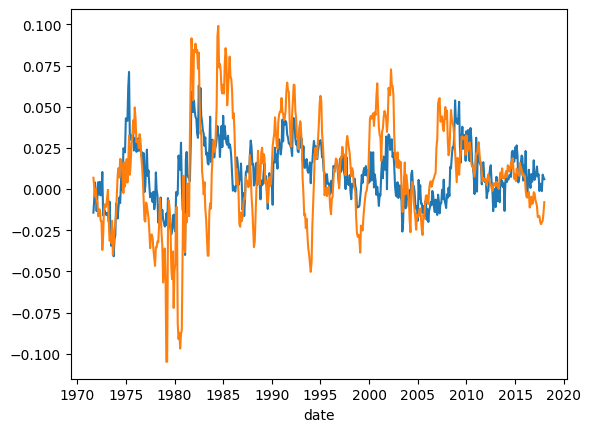

In [ ]:
sns.lineplot(y=model.predict(X), x=yields.index)
sns.lineplot(y=y, x=yields.index)